# CBOW模型建立

In [1]:
from __future__ import print_function
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(filename):
        filename, _ = urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified %s' % filename)
    else:
        print(statinfo.st_size)
        raise Exception('Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [3]:
def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words"""
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


In [4]:
vocabulary_size = 50000

def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count = unk_count + 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]


In [5]:
data_index = 0

def generate_batch(batch_size, skip_window):
    # skip window is the amount of words we're looking at from each side of a given word
    # creates a single batch
    global data_index

    span = 2 * skip_window + 1 # [ skip_window target skip_window ]

    batch = np.ndarray(shape=(batch_size,span-1), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    # e.g if skip_window = 2 then span = 5
    # span is the length of the whole frame we are considering for a single word (left + word + right)
    # skip_window is the length of one side

    # queue which add and pop at the end
    buffer = collections.deque(maxlen=span)

    #get words starting from index 0 to span
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)

    # num_skips => # of times we select a random word within the span?
    # batch_size (8) and num_skips (2) (4 times)
    # batch_size (8) and num_skips (1) (8 times)
    for i in range(batch_size):
        target = skip_window  # target label at the center of the buffer
        target_to_avoid = [ skip_window ] # we only need to know the words around a given word, not the word itself

        # do this num_skips (2 times)
        # do this (1 time)

        # add selected target to avoid_list for next time
        col_idx = 0
        for j in range(span):
            if j==span//2:
                continue
            # e.g. i=0, j=0 => 0; i=0,j=1 => 1; i=1,j=0 => 2
            batch[i,col_idx] = buffer[j] # [skip_window] => middle element
            col_idx += 1
        labels[i, 0] = buffer[target]

        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)

    assert batch.shape[0]==batch_size and batch.shape[1]== span-1
    return batch, labels



for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    
    print('    batch:', [[reverse_dictionary[bii] for bii in bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])


with num_skips = 2 and skip_window = 1:
    batch: [['anarchism', 'as'], ['originated', 'a'], ['as', 'term'], ['a', 'of'], ['term', 'abuse'], ['of', 'first'], ['abuse', 'used'], ['first', 'against']]
    labels: ['originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used']

with num_skips = 4 and skip_window = 2:
    batch: [['anarchism', 'originated', 'a', 'term'], ['originated', 'as', 'term', 'of'], ['as', 'a', 'of', 'abuse'], ['a', 'term', 'abuse', 'first'], ['term', 'of', 'first', 'used'], ['of', 'abuse', 'used', 'against'], ['abuse', 'first', 'against', 'early'], ['first', 'used', 'early', 'working']]
    labels: ['as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [6]:
num_steps = 100001

batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
# pick 16 samples from 100
valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
valid_examples = np.append(valid_examples,random.sample(range(1000,1000+valid_window), valid_size//2))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size,2*skip_window])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Variables.
    # embedding, vector for each word in the vocabulary
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Averaging embeddings accross the full context into a single embedding layer
    context_embeddings = []
    for i in range(2*skip_window):
        context_embeddings.append(tf.nn.embedding_lookup(embeddings, train_dataset[:,i]))
            
    avg_embed =  tf.reduce_mean(tf.stack(axis=0,values=context_embeddings),0,keep_dims=False)

    # Compute the softmax loss, using a sample of the negative labels each time.
    # inputs are embeddings of the train words
    # with this loss we optimize weights, biases, embeddings

    loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=avg_embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

    # Optimizer.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(batch_size, skip_window)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
                # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Initialized
Average loss at step 0: 7.636516
Nearest to these: epicurean, diffusion, iau, gigabytes, unicorn, newnode, beaconsfield, biomes,
Nearest to zero: insubstantial, tobago, antacids, regimen, dishonesty, kidnapping, kenneth, olson,
Nearest to two: droppings, battalion, bartos, lifts, complain, thenceforth, greenpeace, compositing,
Nearest to no: duesberg, rrez, deterrence, admit, rosicrucians, qa, psychiatrists, edsger,
Nearest to in: restraints, unscientific, taint, tilbury, sparrow, amenities, muharram, reptiles,
Nearest to into: siculus, technicolor, chloroplasts, selberg, tracing, chogm, hiawatha, lethality,
Nearest to for: shay, airborne, lace, escaped, accordions, freak, cascades, temperatures,
Nearest to five: priscus, buyer, willows, incarceration, strathclyde, participants, efficie

Average loss at step 42000: 2.942855
Average loss at step 44000: 2.945261
Average loss at step 46000: 2.908744
Average loss at step 48000: 2.868114
Average loss at step 50000: 2.841241
Nearest to these: such, many, some, those, various, several, shalmaneser, both,
Nearest to zero: five, eight, seven, six, four, nine, three, whispers,
Nearest to two: three, four, six, five, eight, seven, nine, one,
Nearest to no: any, roswell, gmt, sorbian, deterrence, australians, energetically, only,
Nearest to in: during, within, at, throughout, bollywood, stared, tilbury, around,
Nearest to into: through, within, from, across, back, under, tracing, over,
Nearest to for: accordions, strategic, wark, against, baxter, shay, lace, when,
Nearest to five: seven, four, six, eight, nine, three, zero, two,
Nearest to test: deshima, narration, donny, fasci, langer, telephus, adapter, tt,
Nearest to centre: vieux, vocal, midair, holographic, center, isma, cretian, quadrature,
Nearest to prince: lagged, prokofi

In [7]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

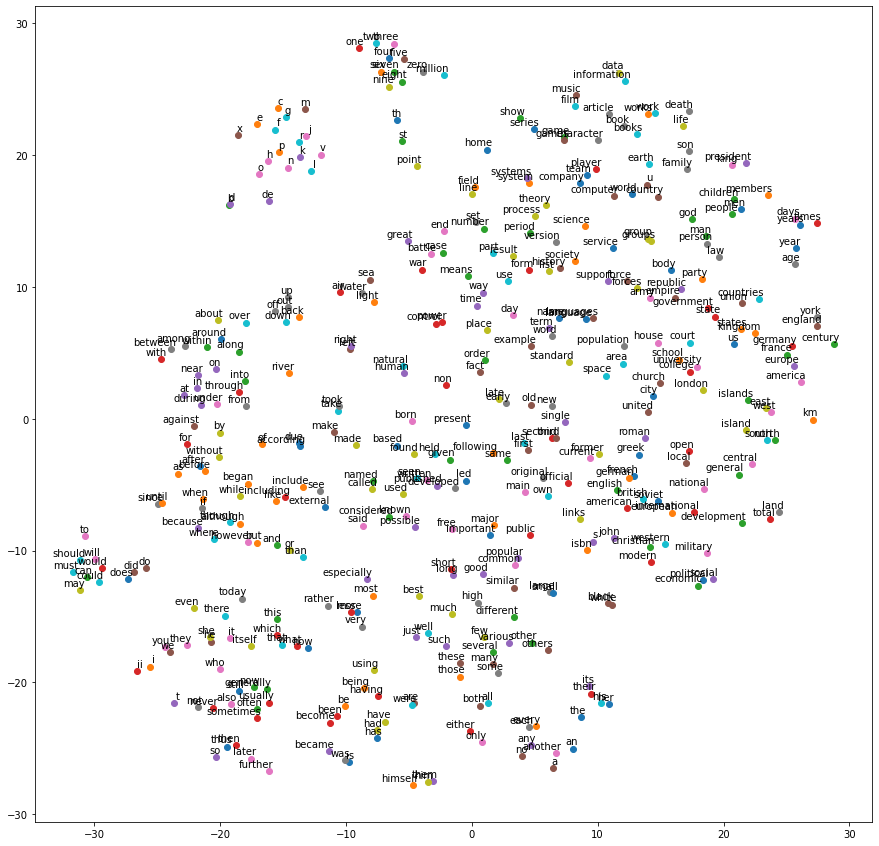

In [8]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

# Gensim套件實作CBOW

In [3]:
import gzip
import gensim
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

data_file="./reviews_data.txt.gz"

with gzip.open ('./reviews_data.txt.gz', 'rb') as f:
    for i,line in enumerate (f):
        print(line)
        break

b"Oct 12 2009 \tNice trendy hotel location not too bad.\tI stayed in this hotel for one night. As this is a fairly new place some of the taxi drivers did not know where it was and/or did not want to drive there. Once I have eventually arrived at the hotel, I was very pleasantly surprised with the decor of the lobby/ground floor area. It was very stylish and modern. I found the reception's staff geeting me with 'Aloha' a bit out of place, but I guess they are briefed to say that to keep up the coroporate image.As I have a Starwood Preferred Guest member, I was given a small gift upon-check in. It was only a couple of fridge magnets in a gift box, but nevertheless a nice gesture.My room was nice and roomy, there are tea and coffee facilities in each room and you get two complimentary bottles of water plus some toiletries by 'bliss'.The location is not great. It is at the last metro stop and you then need to take a taxi, but if you are not planning on going to see the historic sites in Be

In [4]:
def read_input(input_file):
    """This method reads the input file which is in gzip format"""
    
    print("reading file {0}...this may take a while".format(input_file))
    
    with gzip.open (input_file, 'rb') as f:
        for i, line in enumerate (f): 

            if (i%10000==0):
                print("read {0} reviews".format (i))
            # do some pre-processing and return a list of words for each review text
            yield gensim.utils.simple_preprocess (line)

# read the tokenized reviews into a list
# each review item becomes a serries of words
# so this becomes a list of lists
documents = list (read_input (data_file))
print("Done reading data file")

reading file ./reviews_data.txt.gz...this may take a while
read 0 reviews
read 10000 reviews
read 20000 reviews
read 30000 reviews
read 40000 reviews
read 50000 reviews
read 60000 reviews
read 70000 reviews
read 80000 reviews
read 90000 reviews
read 100000 reviews
read 110000 reviews
read 120000 reviews
read 130000 reviews
read 140000 reviews
read 150000 reviews
read 160000 reviews
read 170000 reviews
read 180000 reviews
read 190000 reviews
read 200000 reviews
read 210000 reviews
read 220000 reviews
read 230000 reviews
read 240000 reviews
read 250000 reviews
Done reading data file


In [5]:
documents[0]

['oct',
 'nice',
 'trendy',
 'hotel',
 'location',
 'not',
 'too',
 'bad',
 'stayed',
 'in',
 'this',
 'hotel',
 'for',
 'one',
 'night',
 'as',
 'this',
 'is',
 'fairly',
 'new',
 'place',
 'some',
 'of',
 'the',
 'taxi',
 'drivers',
 'did',
 'not',
 'know',
 'where',
 'it',
 'was',
 'and',
 'or',
 'did',
 'not',
 'want',
 'to',
 'drive',
 'there',
 'once',
 'have',
 'eventually',
 'arrived',
 'at',
 'the',
 'hotel',
 'was',
 'very',
 'pleasantly',
 'surprised',
 'with',
 'the',
 'decor',
 'of',
 'the',
 'lobby',
 'ground',
 'floor',
 'area',
 'it',
 'was',
 'very',
 'stylish',
 'and',
 'modern',
 'found',
 'the',
 'reception',
 'staff',
 'geeting',
 'me',
 'with',
 'aloha',
 'bit',
 'out',
 'of',
 'place',
 'but',
 'guess',
 'they',
 'are',
 'briefed',
 'to',
 'say',
 'that',
 'to',
 'keep',
 'up',
 'the',
 'coroporate',
 'image',
 'as',
 'have',
 'starwood',
 'preferred',
 'guest',
 'member',
 'was',
 'given',
 'small',
 'gift',
 'upon',
 'check',
 'in',
 'it',
 'was',
 'only',
 'co

In [6]:
'''
Word2Vec model parameters

size:
The size of the dense vector to represent each token or word. If you have very limited data, then size should be a much smaller value. If you have lots of data, its good to experiment with various sizes. A value of 100-150 has worked well for me.

window:
The maximum distance between the target word and its neighboring word. If your neighbor's position is greater than the maximum window width to the left and the right, then, some neighbors are not considered as being related to the target word. In theory, a smaller window should give you terms that are more related. If you have lots of data, then the window size should not matter too much, as long as its a decent sized window.

min_count:
Minimium frequency count of words. The model would ignore words that do not statisfy the min_count. Extremely infrequent words are usually unimportant, so its best to get rid of those. Unless your dataset is really tiny, this does not really affect the model.

workers:
How many threads to use behind the scenes?

sg: sg=1 means skip-gram and sg=0 menascbow
'''
model = gensim.models.Word2Vec (documents, size=150, window=10, min_count=2, workers=10, sg=0)
model.train(documents,total_examples=len(documents),epochs=10)

2020-03-06 00:30:38,307 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2020-03-06 00:30:38,310 : INFO : collecting all words and their counts
2020-03-06 00:30:38,311 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-03-06 00:30:38,649 : INFO : PROGRESS: at sentence #10000, processed 1655714 words, keeping 25777 word types
2020-03-06 00:30:38,975 : INFO : PROGRESS: at sentence #20000, processed 3317863 words, keeping 35016 word types
2020-03-06 00:30:39,437 : INFO : PROGRESS: at sentence #30000, processed 5264072 words, keeping 47518 word types
2020-03-06 00:30:39,880 : INFO : PROGRESS: at sentence #40000, processed 7081746 words, keeping 56675 word types
2020-03-06 00:30:40,364 : INFO : PROGRESS: at sentence #50000, processed 9089491 words, keeping 63744 word types
2020-03-06 00:30:40,883 : INFO : PROGRESS: at sentence #60000, processed 11013723 words, keeping 76781 word types
2020-03-06 00:30:41,297 : INFO : PROGRESS: a

2020-03-06 00:31:49,529 : INFO : EPOCH 1 - PROGRESS: at 77.49% examples, 629398 words/s, in_qsize 19, out_qsize 0
2020-03-06 00:31:50,533 : INFO : EPOCH 1 - PROGRESS: at 79.39% examples, 628352 words/s, in_qsize 19, out_qsize 0
2020-03-06 00:31:51,533 : INFO : EPOCH 1 - PROGRESS: at 81.51% examples, 629028 words/s, in_qsize 19, out_qsize 0
2020-03-06 00:31:52,573 : INFO : EPOCH 1 - PROGRESS: at 83.73% examples, 629255 words/s, in_qsize 19, out_qsize 0
2020-03-06 00:31:53,575 : INFO : EPOCH 1 - PROGRESS: at 85.92% examples, 630458 words/s, in_qsize 19, out_qsize 0
2020-03-06 00:31:54,591 : INFO : EPOCH 1 - PROGRESS: at 88.37% examples, 631350 words/s, in_qsize 19, out_qsize 0
2020-03-06 00:31:55,596 : INFO : EPOCH 1 - PROGRESS: at 90.72% examples, 632072 words/s, in_qsize 19, out_qsize 0
2020-03-06 00:31:56,609 : INFO : EPOCH 1 - PROGRESS: at 92.99% examples, 632725 words/s, in_qsize 19, out_qsize 0
2020-03-06 00:31:57,621 : INFO : EPOCH 1 - PROGRESS: at 95.31% examples, 633268 words/s,

2020-03-06 00:32:46,296 : INFO : EPOCH - 2 : training on 41519355 raw words (30349124 effective words) took 46.7s, 650244 effective words/s
2020-03-06 00:32:47,325 : INFO : EPOCH 3 - PROGRESS: at 2.08% examples, 643249 words/s, in_qsize 19, out_qsize 0
2020-03-06 00:32:48,355 : INFO : EPOCH 3 - PROGRESS: at 4.32% examples, 647140 words/s, in_qsize 19, out_qsize 0
2020-03-06 00:32:49,361 : INFO : EPOCH 3 - PROGRESS: at 6.30% examples, 636975 words/s, in_qsize 18, out_qsize 1
2020-03-06 00:32:50,367 : INFO : EPOCH 3 - PROGRESS: at 8.43% examples, 642152 words/s, in_qsize 19, out_qsize 0
2020-03-06 00:32:51,409 : INFO : EPOCH 3 - PROGRESS: at 10.15% examples, 634830 words/s, in_qsize 19, out_qsize 0
2020-03-06 00:32:52,434 : INFO : EPOCH 3 - PROGRESS: at 11.89% examples, 635481 words/s, in_qsize 19, out_qsize 0
2020-03-06 00:32:53,443 : INFO : EPOCH 3 - PROGRESS: at 13.77% examples, 636452 words/s, in_qsize 19, out_qsize 0
2020-03-06 00:32:54,447 : INFO : EPOCH 3 - PROGRESS: at 15.64% exa

2020-03-06 00:33:51,098 : INFO : EPOCH 4 - PROGRESS: at 30.01% examples, 610285 words/s, in_qsize 19, out_qsize 0
2020-03-06 00:33:52,150 : INFO : EPOCH 4 - PROGRESS: at 32.24% examples, 607836 words/s, in_qsize 20, out_qsize 1
2020-03-06 00:33:53,161 : INFO : EPOCH 4 - PROGRESS: at 34.35% examples, 608246 words/s, in_qsize 19, out_qsize 0
2020-03-06 00:33:54,188 : INFO : EPOCH 4 - PROGRESS: at 36.62% examples, 609113 words/s, in_qsize 19, out_qsize 0
2020-03-06 00:33:55,194 : INFO : EPOCH 4 - PROGRESS: at 38.62% examples, 606943 words/s, in_qsize 19, out_qsize 0
2020-03-06 00:33:56,206 : INFO : EPOCH 4 - PROGRESS: at 40.62% examples, 605204 words/s, in_qsize 19, out_qsize 0
2020-03-06 00:33:57,213 : INFO : EPOCH 4 - PROGRESS: at 42.96% examples, 606267 words/s, in_qsize 19, out_qsize 0
2020-03-06 00:33:58,242 : INFO : EPOCH 4 - PROGRESS: at 45.20% examples, 605184 words/s, in_qsize 19, out_qsize 0
2020-03-06 00:33:59,282 : INFO : EPOCH 4 - PROGRESS: at 47.50% examples, 607137 words/s,

2020-03-06 00:34:56,013 : INFO : EPOCH 5 - PROGRESS: at 64.94% examples, 626384 words/s, in_qsize 19, out_qsize 0
2020-03-06 00:34:57,014 : INFO : EPOCH 5 - PROGRESS: at 66.88% examples, 626052 words/s, in_qsize 19, out_qsize 0
2020-03-06 00:34:58,081 : INFO : EPOCH 5 - PROGRESS: at 69.19% examples, 626313 words/s, in_qsize 19, out_qsize 0
2020-03-06 00:34:59,096 : INFO : EPOCH 5 - PROGRESS: at 71.36% examples, 627524 words/s, in_qsize 19, out_qsize 0
2020-03-06 00:35:00,127 : INFO : EPOCH 5 - PROGRESS: at 73.79% examples, 628556 words/s, in_qsize 19, out_qsize 0
2020-03-06 00:35:01,136 : INFO : EPOCH 5 - PROGRESS: at 76.03% examples, 630511 words/s, in_qsize 19, out_qsize 0
2020-03-06 00:35:02,145 : INFO : EPOCH 5 - PROGRESS: at 77.95% examples, 630017 words/s, in_qsize 19, out_qsize 0
2020-03-06 00:35:03,148 : INFO : EPOCH 5 - PROGRESS: at 79.98% examples, 629729 words/s, in_qsize 19, out_qsize 0
2020-03-06 00:35:04,192 : INFO : EPOCH 5 - PROGRESS: at 81.94% examples, 628199 words/s,

2020-03-06 00:35:57,665 : INFO : EPOCH 1 - PROGRESS: at 96.74% examples, 655305 words/s, in_qsize 20, out_qsize 1
2020-03-06 00:35:58,670 : INFO : EPOCH 1 - PROGRESS: at 99.12% examples, 655865 words/s, in_qsize 19, out_qsize 0
2020-03-06 00:35:58,924 : INFO : worker thread finished; awaiting finish of 9 more threads
2020-03-06 00:35:58,930 : INFO : worker thread finished; awaiting finish of 8 more threads
2020-03-06 00:35:58,941 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-03-06 00:35:58,943 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-03-06 00:35:58,949 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-03-06 00:35:58,961 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-03-06 00:35:58,963 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-03-06 00:35:58,964 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-03-06 00:35:58,969 : INFO : worker thre

2020-03-06 00:36:53,746 : INFO : EPOCH 3 - PROGRESS: at 18.09% examples, 668918 words/s, in_qsize 19, out_qsize 0
2020-03-06 00:36:54,752 : INFO : EPOCH 3 - PROGRESS: at 19.89% examples, 670372 words/s, in_qsize 19, out_qsize 0
2020-03-06 00:36:55,754 : INFO : EPOCH 3 - PROGRESS: at 21.90% examples, 670470 words/s, in_qsize 18, out_qsize 1
2020-03-06 00:36:56,758 : INFO : EPOCH 3 - PROGRESS: at 23.60% examples, 668934 words/s, in_qsize 19, out_qsize 0
2020-03-06 00:36:57,766 : INFO : EPOCH 3 - PROGRESS: at 25.80% examples, 671847 words/s, in_qsize 17, out_qsize 2
2020-03-06 00:36:58,781 : INFO : EPOCH 3 - PROGRESS: at 28.36% examples, 672179 words/s, in_qsize 19, out_qsize 0
2020-03-06 00:36:59,842 : INFO : EPOCH 3 - PROGRESS: at 30.93% examples, 672741 words/s, in_qsize 17, out_qsize 2
2020-03-06 00:37:00,845 : INFO : EPOCH 3 - PROGRESS: at 33.42% examples, 673770 words/s, in_qsize 19, out_qsize 0
2020-03-06 00:37:01,846 : INFO : EPOCH 3 - PROGRESS: at 35.86% examples, 676578 words/s,

2020-03-06 00:37:58,654 : INFO : EPOCH 4 - PROGRESS: at 61.86% examples, 669210 words/s, in_qsize 19, out_qsize 0
2020-03-06 00:37:59,659 : INFO : EPOCH 4 - PROGRESS: at 64.55% examples, 670628 words/s, in_qsize 19, out_qsize 0
2020-03-06 00:38:00,669 : INFO : EPOCH 4 - PROGRESS: at 66.71% examples, 670288 words/s, in_qsize 19, out_qsize 0
2020-03-06 00:38:01,694 : INFO : EPOCH 4 - PROGRESS: at 69.17% examples, 671529 words/s, in_qsize 19, out_qsize 0
2020-03-06 00:38:02,752 : INFO : EPOCH 4 - PROGRESS: at 71.44% examples, 671422 words/s, in_qsize 19, out_qsize 0
2020-03-06 00:38:03,794 : INFO : EPOCH 4 - PROGRESS: at 73.54% examples, 668194 words/s, in_qsize 19, out_qsize 1
2020-03-06 00:38:04,841 : INFO : EPOCH 4 - PROGRESS: at 75.40% examples, 664438 words/s, in_qsize 18, out_qsize 1
2020-03-06 00:38:05,848 : INFO : EPOCH 4 - PROGRESS: at 77.47% examples, 664619 words/s, in_qsize 20, out_qsize 0
2020-03-06 00:38:06,854 : INFO : EPOCH 4 - PROGRESS: at 79.63% examples, 664449 words/s,

2020-03-06 00:39:00,778 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-03-06 00:39:00,792 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-03-06 00:39:00,811 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-03-06 00:39:00,812 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-03-06 00:39:00,826 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-03-06 00:39:00,829 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-03-06 00:39:00,831 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-03-06 00:39:00,832 : INFO : EPOCH - 5 : training on 41519355 raw words (30350399 effective words) took 45.0s, 675103 effective words/s
2020-03-06 00:39:01,871 : INFO : EPOCH 6 - PROGRESS: at 1.92% examples, 591422 words/s, in_qsize 20, out_qsize 0
2020-03-06 00:39:02,890 : INFO : EPOCH 6 - PROGRESS: at 4.19% examples, 631573 words/s, in_qsize 19, out_qsize

2020-03-06 00:39:58,646 : INFO : EPOCH 7 - PROGRESS: at 23.64% examples, 666878 words/s, in_qsize 19, out_qsize 0
2020-03-06 00:39:59,717 : INFO : EPOCH 7 - PROGRESS: at 25.90% examples, 667902 words/s, in_qsize 19, out_qsize 0
2020-03-06 00:40:00,720 : INFO : EPOCH 7 - PROGRESS: at 28.49% examples, 669520 words/s, in_qsize 19, out_qsize 0
2020-03-06 00:40:01,730 : INFO : EPOCH 7 - PROGRESS: at 30.73% examples, 666776 words/s, in_qsize 19, out_qsize 0
2020-03-06 00:40:02,749 : INFO : EPOCH 7 - PROGRESS: at 33.09% examples, 664477 words/s, in_qsize 18, out_qsize 1
2020-03-06 00:40:03,768 : INFO : EPOCH 7 - PROGRESS: at 35.41% examples, 665422 words/s, in_qsize 16, out_qsize 3
2020-03-06 00:40:04,794 : INFO : EPOCH 7 - PROGRESS: at 37.65% examples, 663130 words/s, in_qsize 20, out_qsize 0
2020-03-06 00:40:05,818 : INFO : EPOCH 7 - PROGRESS: at 40.02% examples, 661956 words/s, in_qsize 19, out_qsize 0
2020-03-06 00:40:06,835 : INFO : EPOCH 7 - PROGRESS: at 42.10% examples, 656108 words/s,

2020-03-06 00:41:02,848 : INFO : EPOCH 8 - PROGRESS: at 65.63% examples, 660902 words/s, in_qsize 19, out_qsize 0
2020-03-06 00:41:03,849 : INFO : EPOCH 8 - PROGRESS: at 67.66% examples, 659010 words/s, in_qsize 18, out_qsize 1
2020-03-06 00:41:04,853 : INFO : EPOCH 8 - PROGRESS: at 69.75% examples, 658144 words/s, in_qsize 19, out_qsize 0
2020-03-06 00:41:05,921 : INFO : EPOCH 8 - PROGRESS: at 71.86% examples, 656983 words/s, in_qsize 14, out_qsize 5
2020-03-06 00:41:06,973 : INFO : EPOCH 8 - PROGRESS: at 74.17% examples, 655536 words/s, in_qsize 19, out_qsize 0
2020-03-06 00:41:07,994 : INFO : EPOCH 8 - PROGRESS: at 76.09% examples, 653915 words/s, in_qsize 19, out_qsize 0
2020-03-06 00:41:09,007 : INFO : EPOCH 8 - PROGRESS: at 78.16% examples, 653931 words/s, in_qsize 19, out_qsize 0
2020-03-06 00:41:10,009 : INFO : EPOCH 8 - PROGRESS: at 80.45% examples, 655074 words/s, in_qsize 19, out_qsize 0
2020-03-06 00:41:11,028 : INFO : EPOCH 8 - PROGRESS: at 82.61% examples, 654547 words/s,

2020-03-06 00:42:03,915 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-03-06 00:42:03,916 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-03-06 00:42:03,917 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-03-06 00:42:03,938 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-03-06 00:42:03,942 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-03-06 00:42:03,951 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-03-06 00:42:03,952 : INFO : EPOCH - 9 : training on 41519355 raw words (30350223 effective words) took 45.4s, 668269 effective words/s
2020-03-06 00:42:04,980 : INFO : EPOCH 10 - PROGRESS: at 1.74% examples, 539963 words/s, in_qsize 19, out_qsize 0
2020-03-06 00:42:05,998 : INFO : EPOCH 10 - PROGRESS: at 3.79% examples, 578217 words/s, in_qsize 19, out_qsize 0
2020-03-06 00:42:07,001 : INFO : EPOCH 10 - PROGRESS: at 5.83% examples, 593537 words/

(303492517, 415193550)

# 文字類推

In [7]:
# print word vector
model.wv['dirty']

array([-2.6329904 , -3.8092775 , -1.151616  ,  1.5263857 , -0.10239191,
       -0.3176932 , -2.4223788 ,  5.7827578 , -3.6639588 , -2.9150739 ,
        1.1975032 ,  0.33563402, -2.2049477 , -0.11218524, -0.28556168,
       -0.34820792,  0.52400094,  1.414405  ,  2.5404422 ,  4.550944  ,
       -2.6552773 , -0.9514217 , -1.428891  ,  0.53678024,  0.10785449,
       -1.8162004 , -4.308226  ,  2.2984958 ,  3.2975404 , -0.27680567,
       -0.2070539 , -0.2821894 ,  0.4341247 ,  0.95308256,  0.12808235,
        0.46710795, -3.5206208 ,  1.9006801 ,  0.87947893, -0.65941733,
       -1.2850032 ,  0.09494916,  0.388911  ,  0.39984378, -2.9494665 ,
        1.3615822 , -1.1670321 , -2.9094312 , -0.5689286 ,  0.8641652 ,
        2.9333036 ,  1.4651247 ,  2.1830292 ,  1.1034424 ,  0.7664948 ,
       -3.5677774 , -1.6381148 , -1.2241825 ,  6.693606  ,  0.5849955 ,
       -0.8776261 ,  1.5063618 ,  1.4755701 ,  2.450637  ,  2.3951862 ,
       -2.0054696 ,  0.6695978 , -1.0776955 , -2.4433267 ,  3.53

In [8]:
# get everything related to stuff on the bed
w1 = ["bed",'sheet']
w2 = ['couch']
model.wv.most_similar (positive=w1,negative=w2,topn=10)

2020-03-06 08:23:20,359 : INFO : precomputing L2-norms of word weight vectors


[('duvet', 0.637520432472229),
 ('quilt', 0.6242080926895142),
 ('mattress', 0.6185429692268372),
 ('blanket', 0.6083204746246338),
 ('pillowcase', 0.5914482474327087),
 ('pillow', 0.5897761583328247),
 ('matress', 0.5891723036766052),
 ('sheets', 0.574439525604248),
 ('comforter', 0.5325940251350403),
 ('wool', 0.5207309126853943)]